In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import statistics as st
import arviz as az
import bambi as bmb
import pymc as pm
import pymc.sampling_jax
from pymc import HalfNormal, Model, Normal, sample
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc9_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
kidiq = pd.read_stata("../data/kidiq.dta")
kidiq.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


In [4]:
kidiq.groupby(["mom_hs"]).size()

mom_hs
0.0     93
1.0    341
dtype: int64

In [5]:
summary_stats = [st.mean, st.stdev]
kidiq.groupby(["mom_hs"]).aggregate(summary_stats)

kid_score                 mom_iq             mom_work            \
             mean      stdev        mean      stdev      mean     stdev   
mom_hs                                                                    
0.0     77.548387  22.573800   91.889152  12.630498  2.322581  1.226175   
1.0     89.319648  19.049483  102.212049  14.848414  3.052786  1.120727   

          mom_age            
             mean     stdev  
mom_hs                       
0.0     21.677419  2.727323  
1.0     23.087977  2.617453

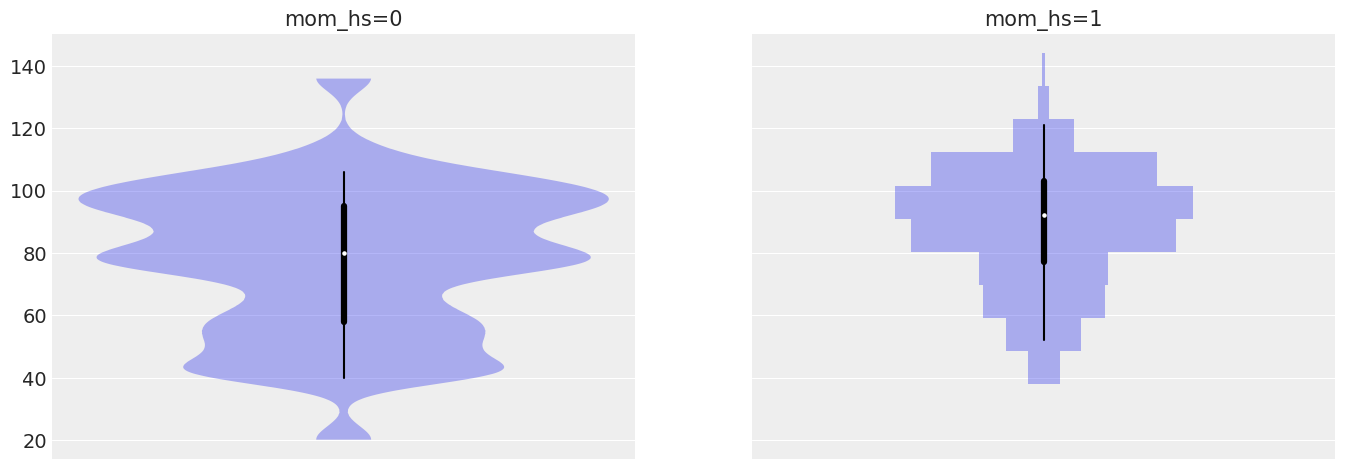

In [6]:
az.plot_violin(
    {
        "mom_hs=0": kidiq.loc[kidiq.mom_hs == 0, "kid_score"],
        "mom_hs=1": kidiq.loc[kidiq.mom_hs == 1, "kid_score"],
    }
);

In [7]:
mod = bmb.Model("kid_score ~ mom_hs", kidiq)

In [8]:
results = mod.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

Compiling...


I0000 00:00:1699423996.664347       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
Compilation time = 0:00:01.268778


Sampling...


  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1454.94it/s]


Running chain 1: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1456.44it/s]


Running chain 2: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1457.63it/s]


Running chain 3: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1458.77it/s]


Sampling time = 0:00:01.581336


Transforming variables...


Transformation time = 0:00:00.059062


Computing Log Likelihood...


Log Likelihood time = 0:00:00.117562


In [9]:
mod

       Formula: kid_score ~ mom_hs
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 86.7972, sigma: 110.1032)
            mom_hs ~ Normal(mu: 0.0, sigma: 124.2132)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [Intercept, kid_score_sigma, mom_hs]


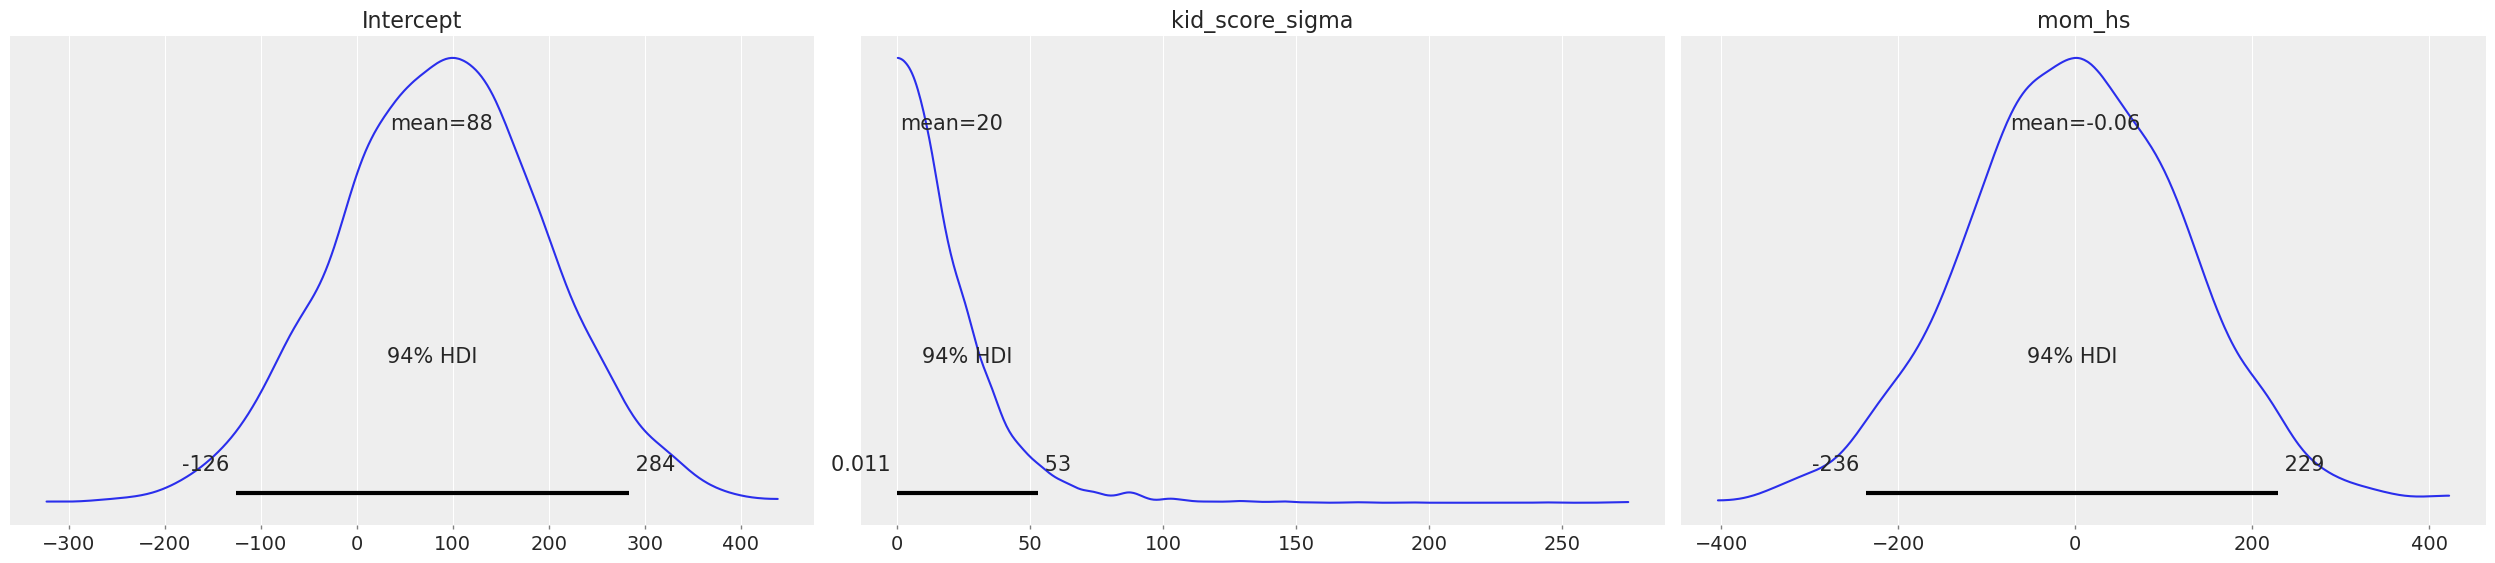

In [10]:
mod.plot_priors();

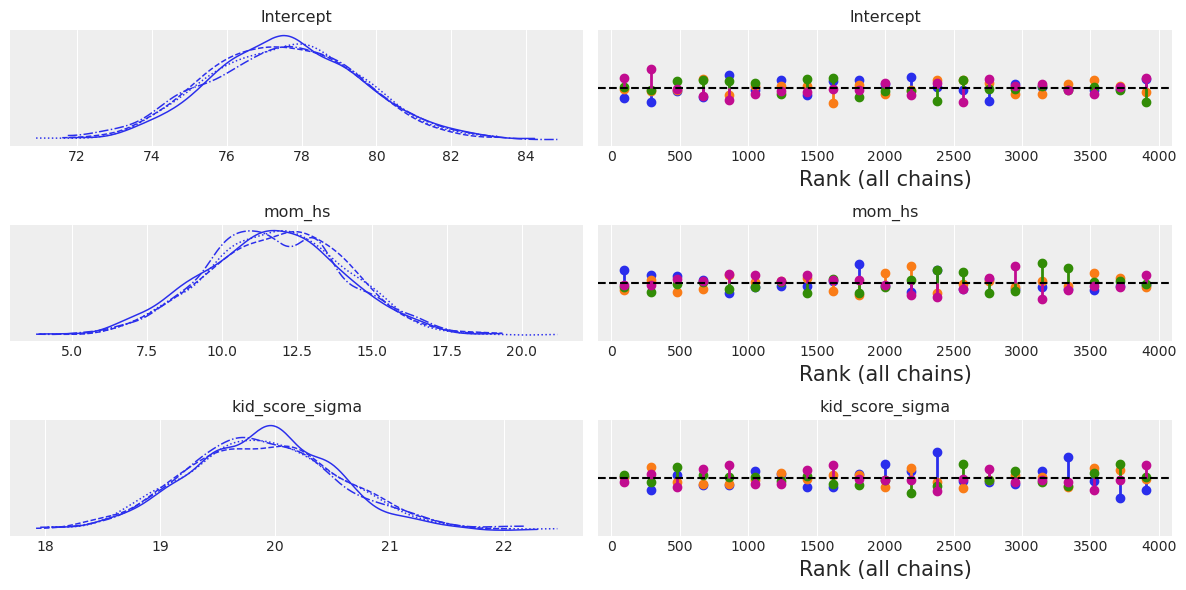

In [11]:
az.plot_trace(results, kind="rank_vlines")
plt.tight_layout()

In [12]:
az.summary(results, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,77.54,2.02,73.72,81.16,0.03,0.02,3611.07,2783.03,1.0
mom_hs,11.80,2.32,7.27,15.89,0.04,0.03,3827.25,2837.17,1.0
kid_score_sigma,19.89,0.67,18.62,21.12,0.01,0.01,3668.17,2808.45,1.0


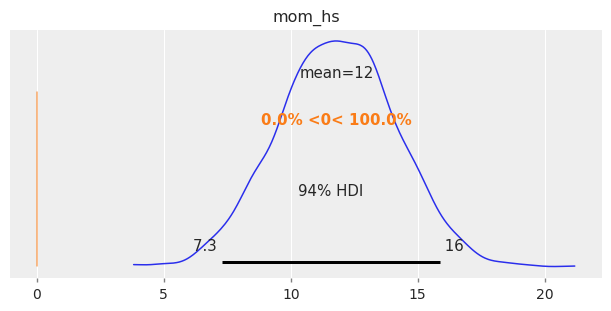

In [13]:
az.plot_posterior(results, var_names="mom_hs", ref_val=0, figsize=(6, 3));

In [14]:
results.posterior

<xarray.Dataset>
Dimensions:          (chain: 4, draw: 1000)
Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
Data variables:
    Intercept        (chain, draw) float64 79.45 77.16 76.79 ... 76.79 78.11
    mom_hs           (chain, draw) float64 10.72 11.02 11.41 ... 12.58 10.81
    kid_score_sigma  (chain, draw) float64 19.19 19.31 19.66 ... 19.94 19.72
Attributes:
    created_at:                  2023-11-08T06:13:18.516424
    arviz_version:               0.16.1
    modeling_interface:          bambi
    modeling_interface_version:  0.12.0

In [15]:
# Probabiliy that posterior is > 0
(results.posterior["mom_hs"] > 0).mean().item()

1.0

In [16]:
# Add a new column 'hs' with the categories based on 'mom_hs'
kidiq["hs"] = kidiq["mom_hs"].map({0: "not_completed", 1: "completed"})
kidiq.tail()

,kid_score,mom_hs,mom_iq,mom_work,mom_age,hs
429,94,0.0,84.877412,4,21,not_completed
430,76,1.0,92.990392,4,23,completed
431,50,0.0,94.859708,2,24,not_completed
432,88,1.0,96.856624,2,21,completed
433,70,1.0,91.253336,2,25,completed


In [17]:
mod_2 = bmb.Model("kid_score ~ 0 + hs", kidiq)
results_2 = mod_2.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:00.499685


Sampling...


  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1598.93it/s]


Running chain 1: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1600.02it/s]


Running chain 2: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1601.64it/s]


Running chain 3: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1603.29it/s]


Sampling time = 0:00:01.332193


Transforming variables...


Transformation time = 0:00:00.052269


Computing Log Likelihood...


Log Likelihood time = 0:00:00.089027


In [18]:
mod_2

       Formula: kid_score ~ 0 + hs
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            hs ~ Normal(mu: [0. 0.], sigma: [124.2132 124.2132])
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [hs, kid_score_sigma]


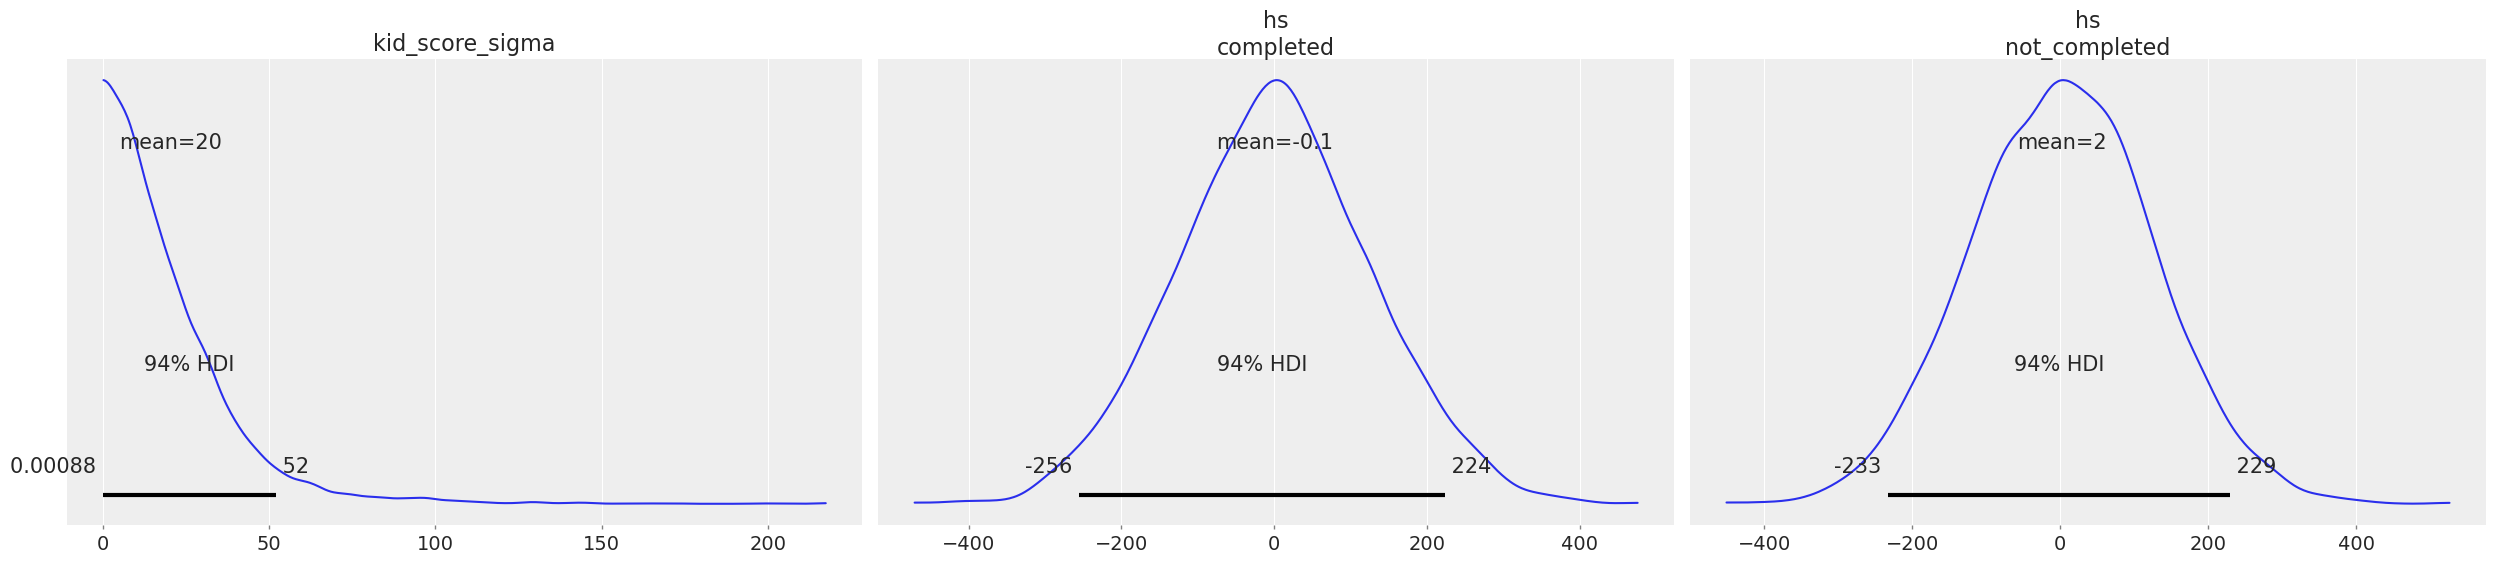

In [19]:
mod_2.plot_priors();

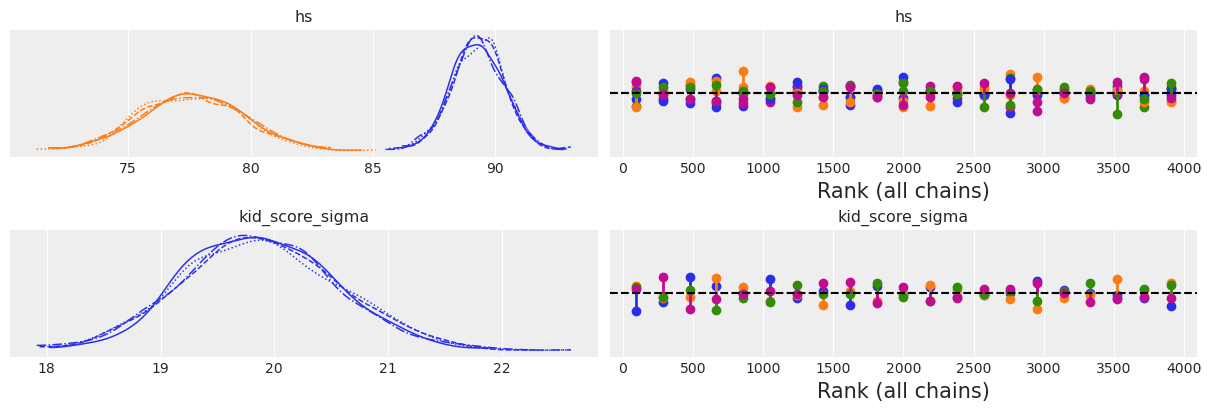

In [20]:
az.plot_trace(results_2, kind="rank_vlines");

In [21]:
az.summary(results_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hs[completed],89.296,1.074,87.318,91.357,0.017,0.012,4046.0,3128.0,1.0
hs[not_completed],77.604,2.064,73.643,81.410,0.032,0.023,4115.0,2984.0,1.0
kid_score_sigma,19.879,0.681,18.639,21.182,0.010,0.007,4673.0,2924.0,1.0


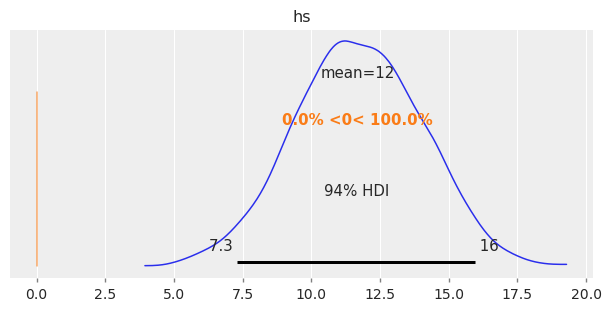

In [22]:
post_group = results_2.posterior["hs"]
diff = post_group.sel(hs_dim="completed") - post_group.sel(hs_dim="not_completed")
az.plot_posterior(diff, ref_val=0, figsize=(6, 3));

In [23]:
# Probabiliy that posterior is > 0
(post_group > 0).mean().item()

1.0

In [24]:
μ_m = kidiq.kid_score.mean()
μ_s = kidiq.kid_score.std() * 3

with Model() as model:
    # Priors
    alpha = Normal("alpha", mu=μ_m, sigma=μ_s)
    beta = Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=30)
    # Expected value of outcome
    mu = alpha + beta * kidiq["mom_hs"] 
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=kidiq["kid_score"])

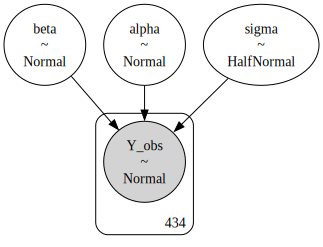

In [25]:
pm.model_to_graphviz(model)

In [26]:
with model:
    prior_samples = pm.sample_prior_predictive(1000)

Sampling: [Y_obs, alpha, beta, sigma]


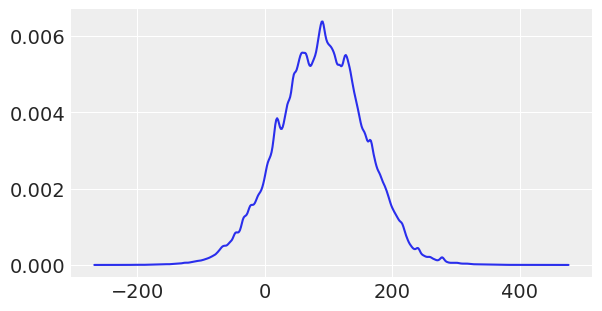

In [27]:
az.plot_dist(prior_samples.prior_predictive["Y_obs"], figsize=(6, 3));

In [28]:
with model:
    trace = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:00.423322


Sampling...


  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1428.89it/s]


Running chain 1: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1429.80it/s]


Running chain 2: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1431.07it/s]


Running chain 3: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1432.35it/s]


Sampling time = 0:00:01.461042


Transforming variables...


Transformation time = 0:00:00.036446


In [29]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,77.92,1.99,74.21,81.52,0.05,0.04,1339.63,1809.81,1.01
beta,11.27,2.23,7.10,15.39,0.06,0.04,1309.79,1818.73,1.01
sigma,19.89,0.69,18.68,21.27,0.01,0.01,2117.52,2082.41,1.00


In [30]:
with Model() as model:
    # Priors
    alpha = Normal("alpha", mu=μ_m, sigma=μ_s)
    beta = Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=30)
    # Expected value of outcome
    mu = alpha + beta * kidiq["mom_hs"] 
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=kidiq["kid_score"])
    
    effect_size = pm.Deterministic("effect size", beta / sigma)
    
    trace = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:00.502826


Sampling...


  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1477.04it/s]


Running chain 1: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1477.86it/s]


Running chain 2: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1479.04it/s]


Running chain 3: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1480.31it/s]


Sampling time = 0:00:01.416040


Transforming variables...


Transformation time = 0:00:00.041385


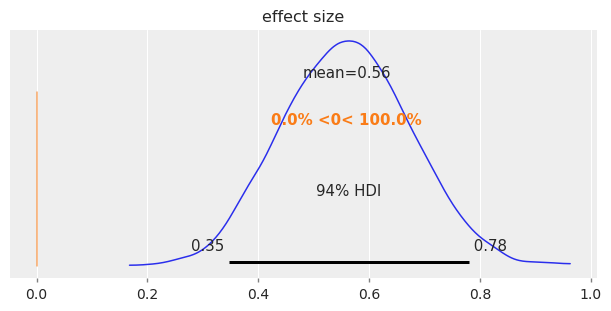

In [31]:
az.plot_posterior(trace, ref_val=0, var_names=["effect size"], figsize=(6, 3));

In [32]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,78.04,2.04,74.12,81.69,0.05,0.04,1434.66,1581.30,1.0
beta,11.14,2.30,7.01,15.57,0.06,0.04,1511.61,1582.43,1.0
sigma,19.92,0.68,18.61,21.13,0.01,0.01,2109.07,2098.75,1.0
effect size,0.56,0.12,0.35,0.78,0.00,0.00,1506.35,1786.89,1.0


In [33]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Nov 08 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

pytensor: 2.13.1

scipy     : 1.11.3
pymc      : 5.9.1
arviz     : 0.16.1
matplotlib: 3.8.0
numpy     : 1.25.2
pandas    : 2.1.1
bambi     : 0.12.0
seaborn   : 0.13.0

Watermark: 2.4.3

